スタッキングしてみる

In [42]:
%matplotlib inline
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import arange, hamming, sin, pi
from scipy.fftpack import fft, ifft
from scipy import stats
from hyperopt import fmin, tpe, hp, rand

from sklearn.decomposition import PCA, KernelPCA
from sklearn import svm
from sklearn import model_selection

from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import BayesianRidge

In [65]:
# 波形の可視化
def viz_signal(X_viz_train, y_viz_train=None, X_on_draw=None, ymin=1.3, ymax=1.7):
    label_flg = False
    draw_flg = False
    if y_viz_train is not None:
        label_flg = True
    if X_on_draw is not None:
        draw_flg = True
        
    for i, x in enumerate(X_viz_train):
        plt.subplot(len(X_viz_train),1, i+1)
        plt.plot(x)
        
        # 上に書くなら
        if draw_flg:
            plt.plot(X_on_draw[i])
            
        plt.xlim(0,len(x))
        plt.ylim(ymin, ymax)
        
        if label_flg:
            plt.ylabel(int(y_viz_train[i]), fontsize=8)
        else:
            plt.ylabel(i, fontsize=8)  
    plt.show()

# ゼロを中央値に置き換える
def zero2median(X):
    dvs = []
    for xs in X:
        xs[np.isnan(xs)] = np.nanmedian(xs)
        dvs.append(xs)
    return np.array(dvs)

# 波形データを分割してシャッフル
def data_generator(X_, y_=None, w_size = 4096, offset = 500):
    if y_ is None:
        # ラベルがないとき(test)
        X_sub = []
        for n, x in enumerate(X_):
            for i in range(0, len(x)-w_size, offset):
                X_sub.append(x[i:i+w_size])
        return np.array(X_sub)
    else:
        # ラベルがあるとき(train)
        X_sub, y_sub = [], []
        for n, (x, y) in enumerate(zip(X_, y_)):
            for i in range(0, len(x)-w_size, offset):
                X_sub.append(x[i:i+w_size])
                y_sub.append(y)
        X, y = np.array(X_sub), np.array(y_sub)
        # データをシャッフルする
        data_size = len(y)
        shuffle_idx = random.sample(range(data_size), k=data_size) 
        return X[shuffle_idx], y[shuffle_idx] 


# 標準偏差が閾値内なら使用する
def data_selection_std(X_, y_, th_max=0.3, th_min=0.001):
    X, y = [], []
    for (xp, yp) in zip(X_, y_):
        if np.std(xp) > th_min and np.std(xp) < th_max:
            X.append(xp)
            y.append(yp)
        #else:
        #    print(xp, np.std(xp))

    return np.array(X), np.array(y)

# フーリエ変換
def transform_fft(X_):
    # サンプル長
    N = X_.shape[1]
    X_fft = []
    for x in X_:
        # 高速フーリエ変換
        win = hamming(N)
        F = np.fft.fft(x*win)#/(N/2)
        # 直流成分の振幅を揃える
        # F[0] = F[0]/2
        #amp = [np.sqrt(c.real ** 2 + c.imag ** 2) for c in F]
        # なぜか実部だけの方が予測性能がいい
        amp = [c.real  for c in F]
        # ナイキスト周波数の範囲内のデータのみ取り出し
        X_fft.append(amp[0:int(N/2)-1])
    return np.array(X_fft)

# 平滑化フィルタ
def savgol(X):
    X_ = []
    for xf in X:
        x_f = signal.savgol_filter(xf, 21, 3, mode="mirror")
        X_.append(x_f) 
    return np.array(X_)

# データの前処理
def data_preproc(X_, y_=None, datalen=None):
    if y_ is not None:
        X_pre, y_pre = data_generator(X_, y_, w_size=datalen, offset=datalen-1)
        X_d, y_d = data_selection_std(X_pre, y_pre) 
        X_f = savgol(X_d)
        X_fft = transform_fft(X_f)
        return X_fft, y_d     
    else:
        X_pre = data_generator(X_, w_size=datalen, offset=datalen-1)
        X_f = savgol(X_pre)
        X_fft = transform_fft(X_f)
        return X_fft

# 次元圧縮
def data_sequence(X_, dim=16, kernel_pca='rbf'):
    # 標準化1
    X_std_ = stats.zscore(X_, axis=1)
    # 主成分分析
    pca = KernelPCA(n_components=int(dim), kernel=kernel_pca)
    X_pca_ = pca.fit_transform(X_std_)
    #標準化2
    X_std2_ = stats.zscore(X_pca_, axis=1)
    return X_std2_   

# 任意の個数にデータを分ける (split, term, dim)
def k_fold_data(X_, y_=None, n_split=10):
        n_term = X_.shape[0] // n_split
        X = X_[:n_term*n_split]
        X = X.reshape(n_split, n_term, X_.shape[1])
        if y_ is not None:
            y = y_[:n_term*n_split]
            y = y.reshape(n_split, n_term)
            return X, y     
        return X   

# 交差検定みたいな X_.shape=(k, n, d), y_shape=(k, n)
def k_fold_separate(X_, y_, k_idx=0):
    X_set = np.empty((0, X_.shape[2]), float)
    y_set = np.empty((0,), float)
    for i, (X, y) in enumerate(zip(X_, y_)):
        if i == k_idx:
            continue
        else:
            X_set = np.append(X_set, X, axis=0)
            y_set = np.append(y_set, y, axis=0)            
    return (X_set, y_set, X_[k_idx].reshape(-1, X_.shape[2]), y_[k_idx].reshape(-1,))

In [97]:
# パラメータ置き場
estimators = [10, 50, 100]#, 500, 1000]
features = ['auto','sqrt','log2']

rfr_space = [
    hp.choice('n_estimators', [i for i in range(len(estimators))]),#結局indexで帰ってくるので
    hp.choice('max_features', [i for i in range(len(features))]),
    hp.uniform('min_samples_split', 2, 10),
    hp.uniform('max_depth', 2, 10)
]

In [67]:
# データ読み込み
df_src = pd.read_csv("train.tsv", delimiter='\t')

print("train shape:", df_src.shape)
    
df = df_src.replace(0, np.nan)
X_train = zero2median(df.values[:,1:-1])
print(X_train.shape)
y_train = df.values[:,-1]

# 外れ値のカット
min_idx = np.where(y_train==93)[0]
max_idx = np.where(y_train==295)[0]

X_train = np.delete(X_train, [min_idx, max_idx], 0)
y_train = df.values[:,-1]
y_train = np.delete(y_train, [min_idx, max_idx], 0)

print(X_train.shape)
print(y_train.shape)



datalen=10000
#datalen=5000

#波形データをfftして折りたたんで増やす
X_train, y_train = data_preproc(X_train, y_train, datalen=datalen)
#print(y_train, y_train.shape)
#次元圧縮
X_train_d = data_sequence(X_train, dim=16, kernel_pca='rbf')

#スタッキング用にデータを分割
n_split=8
X_train_sl, y_train_sl = k_fold_data(X_train_d, y_train, n_split=n_split)
print(X_train_sl.shape, y_train_sl.shape, y_train_sl.shape[0]*y_train_sl.shape[1])


train shape: (144, 30002)
(144, 30000)
(142, 30000)
(142,)
(8, 45, 16) (8, 45) 360


In [ ]:
#count = 0
def rfr_func(args):
    n_estimators, max_features, min_samples_split, max_depth = args
    clf_ = RandomForestRegressor(n_estimators=estimators[n_estimators], max_features=features[max_features], 
                                 min_samples_split=int(min_samples_split), max_depth=int(max_depth))
    scores = model_selection.cross_val_score(estimator=clf_, X=X_data, y=y_data, cv=10)
    mean_scores = scores.mean()
    #global count
    #print(count, mean_scores, scores.std())
    #count+=1
    return -mean_scores

In [110]:
def use_model(model='rfr', args=None, train=True):
    if model=='rfr':
        if train:
            n_estimators, max_features, min_samples_split, max_depth = args
        else:
            n_estimators=args['n_estimators']
            max_features=args['max_features']
            min_samples_split=args['min_samples_split']
            max_depth=args['max_depth']
        clf = RandomForestRegressor(n_estimators=estimators[n_estimators], max_features=features[max_features], 
                                    min_samples_split=int(min_samples_split), max_depth=int(max_depth))
        return clf

# 分割した回数だけ交差検定する
max_evals=3
y_blend_set = np.empty((0,), float)
params = []
model_params = {}
models = ['rfr']
for i in range(X_train_sl.shape[0]):
    
    X_fold_train, y_fold_train, X_fold_test, y_fold_test = k_fold_separate(X_train_sl, y_train_sl, i)
    
    def rfr_func(args):
        clf_ = use_model(model='rfr', args=args)
        scores = model_selection.cross_val_score(estimator=clf_, X=X_fold_train, y=y_fold_train, cv=10)
        mean_scores = scores.mean()
        print(i, mean_scores, scores.std())
        return -mean_scores
    
    rfr_best_args = fmin(rfr_func, rfr_space, algo=tpe.suggest, max_evals=max_evals)
    params.append(rfr_best_args)
    #print(rfr_best_args)
    
    model = use_model(model='rfr', args=rfr_best_args, train=False)
    clf = model.fit(X_fold_train, y_fold_train)
    # ブレンドデータの作成
    y_blend = clf.predict(X_fold_test)
    y_blend_set = np.append(y_blend_set, y_blend, axis=0)

    
model_params['rfr'] = params
#print(y_blend_set.shape, y_blend_set-y_train_sl.reshape(-1,))
print(model_params)    


0 -0.0474853818563 0.0669309188655
0 -0.0522764810169 0.0745852076536
0 -0.0464718483895 0.0737340677391
1 -0.0565411821874 0.139257852684
1 -0.010366656688 0.101069727463
1 -0.0336495269811 0.0953251714832
2 -0.0389357004529 0.0721989223168
2 -0.0303753661058 0.0740995070186
2 -0.0143631619445 0.086688290797
3 -0.0567627700533 0.0823149767904
3 -0.0211223410726 0.0537665323352
3 -0.0220297510411 0.0462080797672
4 0.000223957993728 0.0777609196816
4 -0.0804695597079 0.151757702187
4 -0.0127049617658 0.0896608959501
5 -0.0693568148793 0.071414045341
5 -0.0657897186179 0.0907823796425
5 -0.0864643784558 0.111854609705
6 -0.0260020101775 0.0653690643857
6 -0.129862686736 0.0927877882654
6 -0.0337927379924 0.0963851218205
7 -0.0421543690585 0.059001664829
7 -0.0442333532488 0.047838383504
7 -0.0451144492805 0.0381641773662
{'rfr': [{'max_depth': 3.3340167750234757, 'max_features': 2, 'min_samples_split': 6.6605782990427915, 'n_estimators': 1}, {'max_depth': 7.8389607832598065, 'max_feature

-0.101544920294 29.486418171 29.4865930199


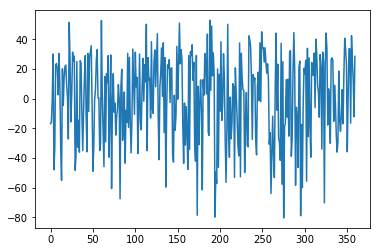

In [108]:
diff=y_blend_set-y_train_sl.reshape(-1,)
mse = np.sqrt(diff.T.dot(diff)/len(diff))
print(data.mean(), data.std(), mse)
plt.plot(data)
plt.show()